<a href="https://colab.research.google.com/github/grc22/FFT-Imperial/blob/main/FFTSeminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Oscillations and Waves - Seminar 8 - The Fast Fourier Transform**

In this Jupyter notebook, you will investigate the applications of the Fast Fourier Transform (FFT).  

In the first section, you will take a defined periodic curve, digitise it, and then add some noise to it.  You will then investigate how using the FFT to look at the curve in frequency space allows you to remove the noise.

In the second section, you will look at a series of audio files where we have added noise.  Again, you will use the FFT to assist you in making the audio files understandable.

In the final section, you will investigate the use of the FFT (in two dimensions) in compressing photographs.

Note that much of this exercise and code is based upon the youtube series on Fourier Analysis by Steve Brunton.

We will start off by running some code to import the libraries that we will need and define a couple of functions that we will be using repeatedly.  Just hit the "play" button in the upper left corner to run this module.



In [ ]:
!pip install pydub

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import os
import wave
from skimage import io, color
from google.colab import drive
from ipywidgets import interactive
#from IPython.display import display
import IPython.display as ipd
from pydub import AudioSegment
from pydub.playback import play
from matplotlib.image import imread

plt.rcParams ['figure.figsize'] = [16, 12]
plt.rcParams['font.size'] = 18

def get_integer_input_var(PromptPhrase):
    user_input_str = input(PromptPhrase)
    while True:
        try:
            user_integer = int(user_input_str)
            return user_integer
        except ValueError:
            print("Invalid input. Please enter a valid integer.")

def get_real_number(prompt_phrase):
    while True:
        try:
            # Display the prompt and get user input
            user_input = input(prompt_phrase)

            # Convert the user input to a float
            real_number = float(user_input)

            # If the conversion is successful, break the loop and return the real number
            break
        except ValueError:
            # If the conversion fails, print an error message and continue the loop
            print("Invalid input. Please enter a valid real number.")

    return real_number

# **A. De-noising a Curve**

In this module we will start with a curve that is a combination of sine functions.  We will digitise this (i.e. take samples of our function for a discrete set of $x$ values) and then add in some noise artificially.  Below, you will FFT this data into frequency space and then eliminate the noise.  Once you inverse FFT the resulting dataset, hopefully you will end up with your original curve.

In the following code we create a discrete set of data (1000 points between $t=0$ and $t=1$) based upon $f(t)=\sin(30\times2\pi t)+\sin(100\times2\pi t)$. For each point in time, we add a random variable which is uniformly distributed between -3 and 3 resulting in a very noisy looking curve.  Feel free to change these default values to investigate their impact on this exercise.


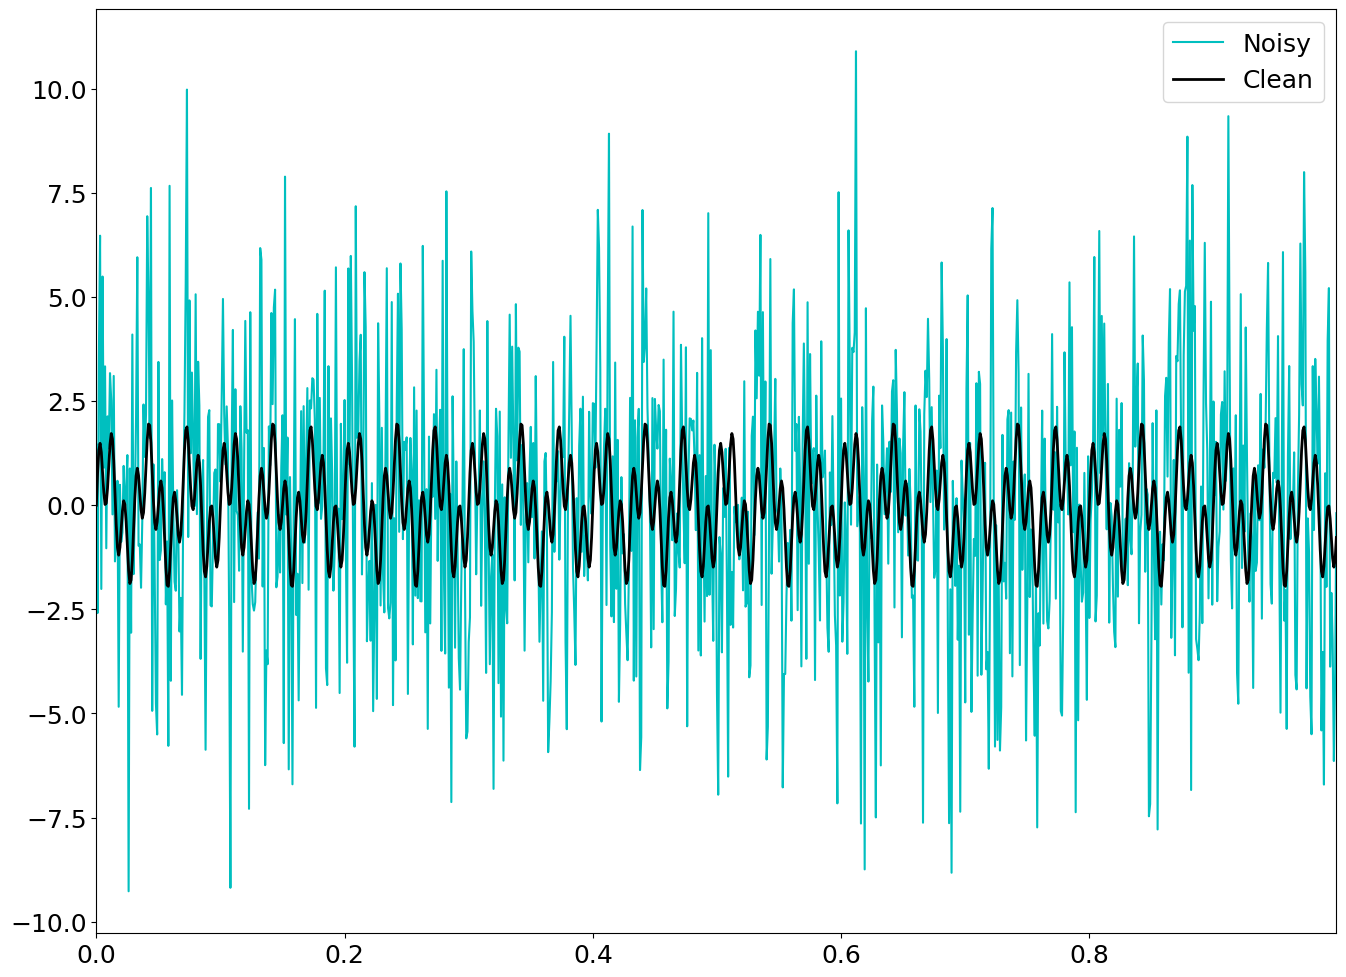

In [ ]:
dt = 0.001  # distance between time values for sampling
random_size=3
freq1=30
freq2=100
amp1=1
amp2=1   # These four parameters define the periodic curve which is a sum of two sine curves
t = np.arange (0,1,dt)
f = amp1*np.sin(2*np.pi*freq1*t)+amp2*np.sin(2*np.pi*freq2*t)  # a digital file representing the sum of sine curves
f_clean = f
f = f + random_size*np.random.randn(len(t))  #adding noise to the clean curve

plt.plot(t,f, color = 'c', linewidth = 1.5, label = 'Noisy')
plt.plot(t,f_clean, color = 'k', linewidth = 2, label = 'Clean')
plt.xlim(t[0],t[-1])
plt.legend()


You can see in the graph above that the noisy data completely obscures the clean curve.  Let's use the FFT to see how this looks in frequency space.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


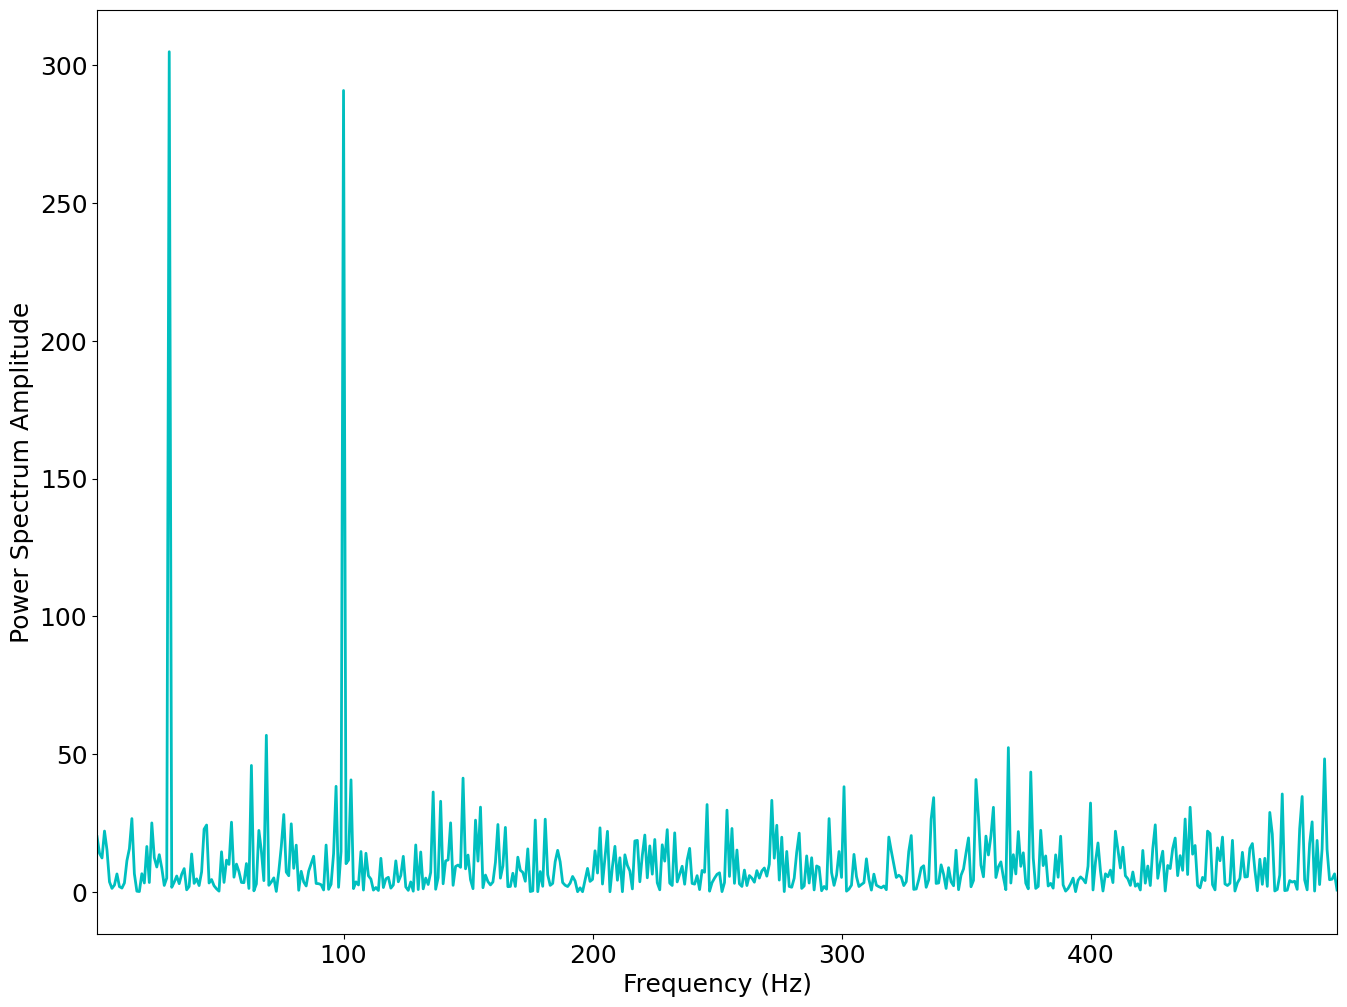

In [ ]:
n=len(t)  # Find length of the time vector
fhat = np.fft.fft(f,n)  #  Use the fast fourier transform on f
PSD = fhat * np.conj(fhat) / n    # Calculate the power spectrum
freq = 1/(dt*n) * np.arange(n)    # Calculate the frequencies associated with fhat
L = np.arange(1, np.floor(n/2), dtype = 'int')

plt.plot(freq[L],PSD[L], color = 'c', linewidth = 2)
#plt.plot(freq[L], y_horizontal_line, color='red', linestyle='--')
plt.xlim(freq[L[0]],freq[L[-1]])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectrum Amplitude")
plt.show()


In frequency space it is usually much easier to separate the noise from the true signal.  In this case decide what frequencies to keep by specifying a minimum amplitude.  Only frequencies with amplitudes greater than what is specified will be kept.

Enter a minimum amplitude:80
You entered: 80.0


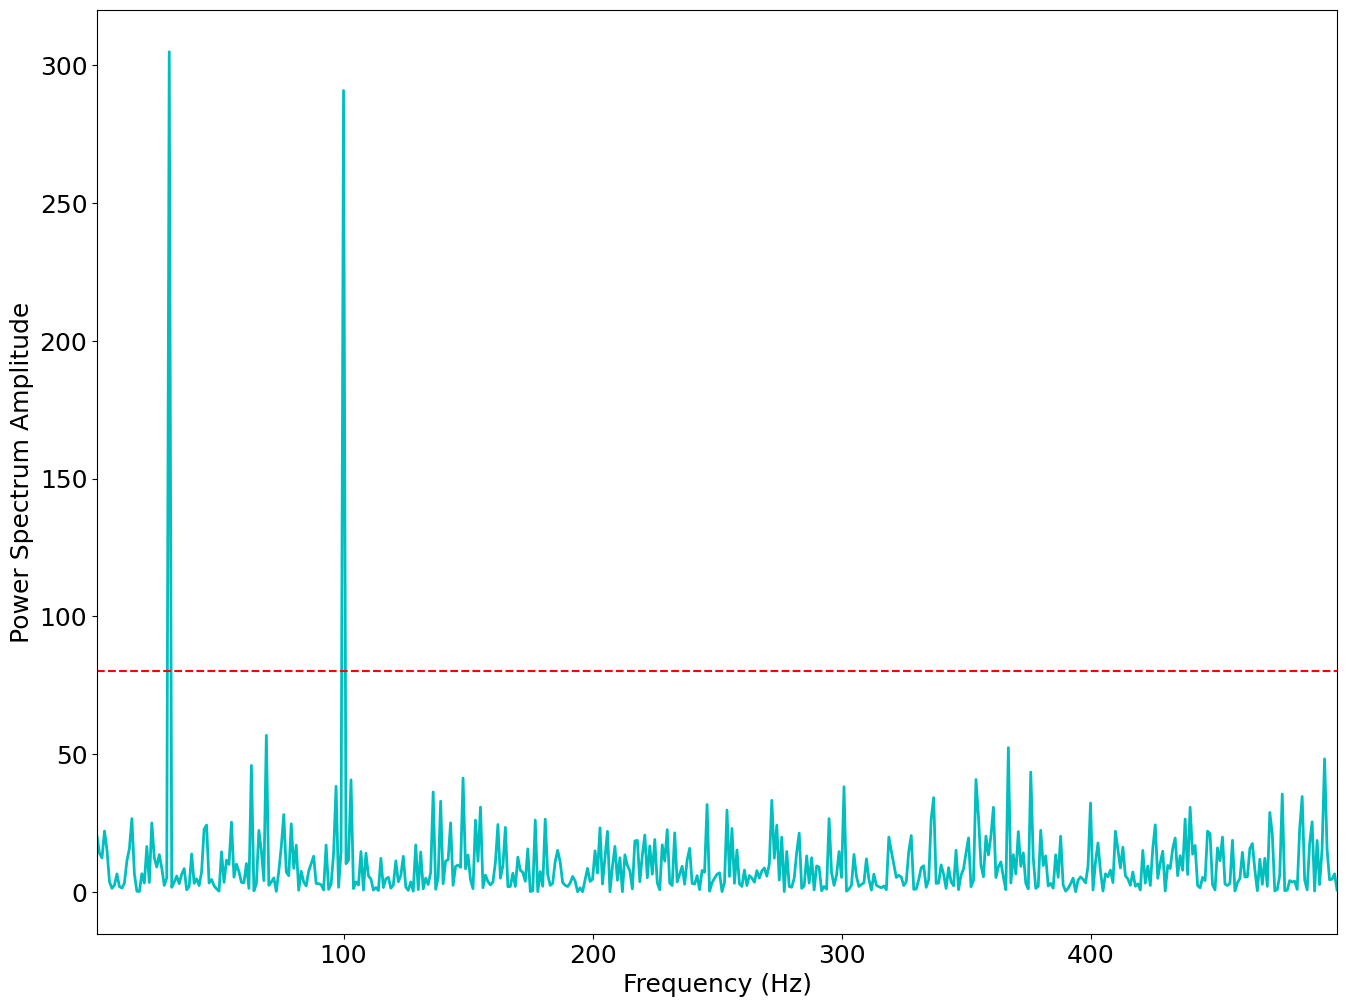

In [ ]:
min_amplitude = get_real_number("Enter a minimum amplitude:")
print("You entered:", min_amplitude)
y_horizontal_line = [min_amplitude] * len(L)

fhat_clean=fhat*(PSD>min_amplitude)

plt.plot(freq[L],PSD[L], color = 'c', linewidth = 2)
plt.plot(freq[L], y_horizontal_line, color='red', linestyle='--')
plt.xlim(freq[L[0]],freq[L[-1]])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectrum Amplitude")
plt.show()


Now we do the inverse Fourier transform using the FFT and (hopefully) we will retrieve the clean signal.

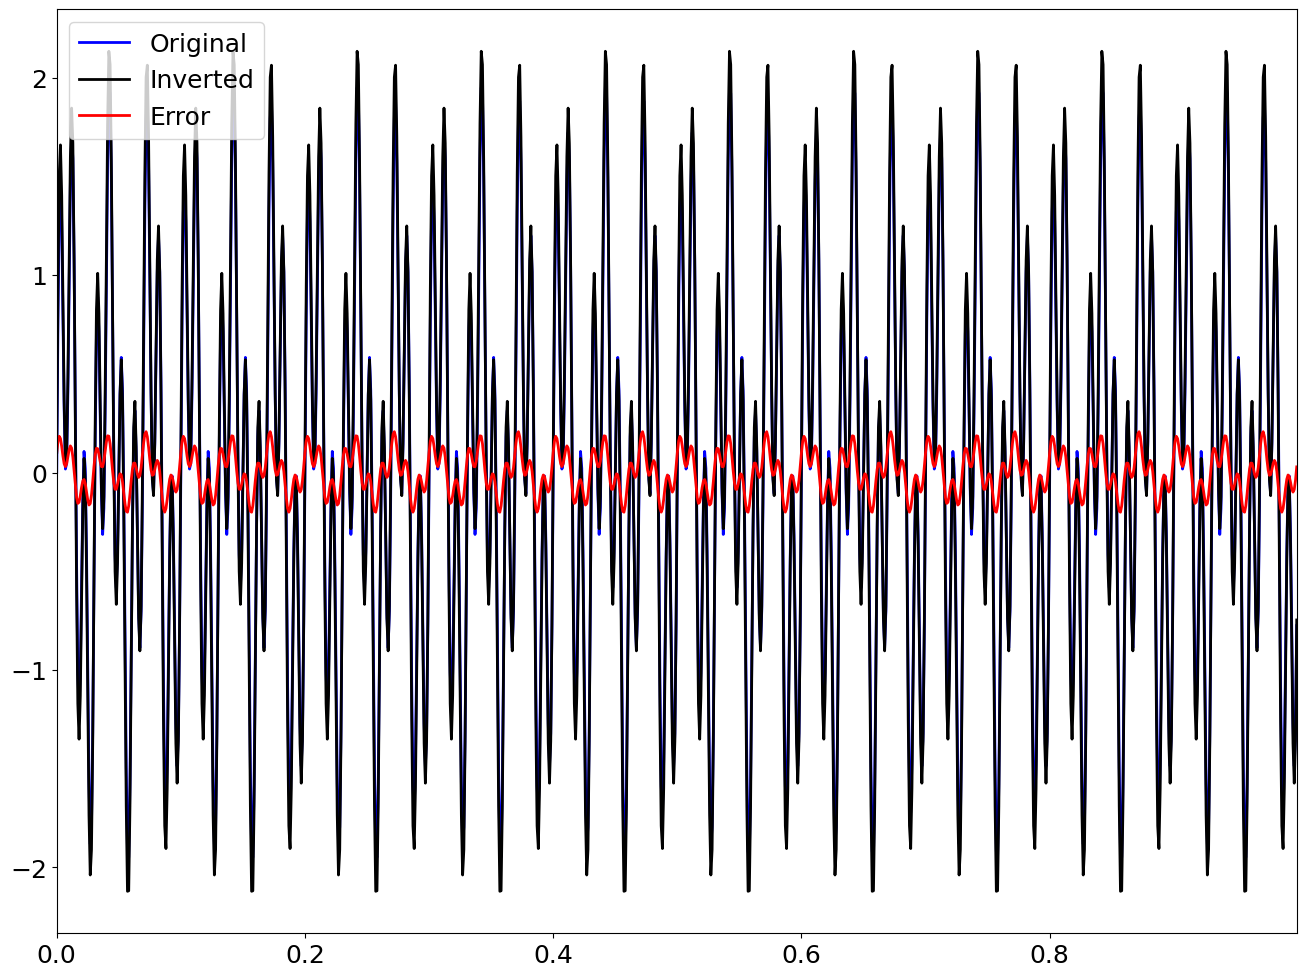

In [ ]:
f_inverse=np.fft.ifft(fhat_clean)
f_error=f_inverse-f_clean

plt.plot(t, f_clean, color = 'b', linewidth = 2, label = 'Original')
plt.plot(t,f_inverse, color = 'k', linewidth = 2, label = 'Inverted')
plt.plot(t,f_error, color = 'r', linewidth = 2, label = 'Error')
plt.xlim(t[0],t[-1])
plt.legend()



a) Note that there is a small difference between the original curve and the recovered curve.  Why is that?

b) The default magnitude of the random errors is 3 while the magnitude of the clean data is at most 2.  Vary the size of the random error ("random_size") in the first cell to see when the noise becomes too dominant so that you are unable to retrieve the original signal.

#B. De-noising Audio Files

The first example was quite artificial in that we knew what the clean data was and then polluted it with random noise.  In this example, you are to take audio files that have been corrupted with some noise and you are to use the FFT to figure out how to manipulate the data in frequency space in order to retrieve the original audio file.

The first step, upload the audio file with your table number.  Once you go through this, you can give the other 12 corrupted audio files a shot.  Play the file - it should just be white noise.

What audio file would you like to load (1-13)?:  1
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


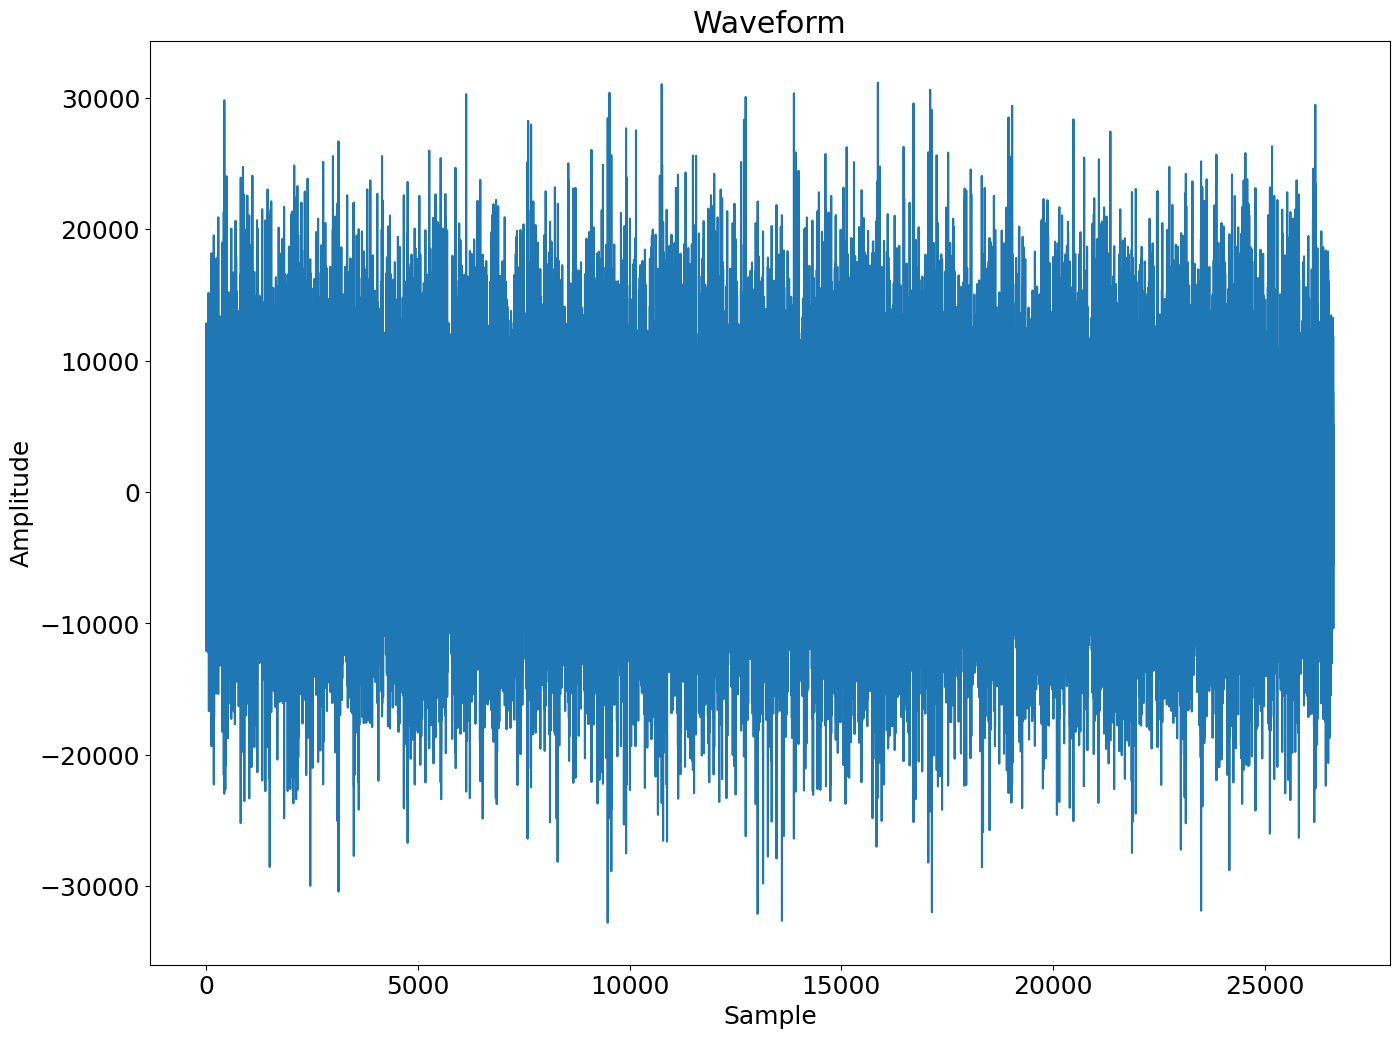

In [ ]:
audio_file_index = get_integer_input_var("What audio file would you like to load (1-13)?:  ")

# Mount Google Drive to access files
drive.mount('/content/gdrive')

# Specify the path to your .wav file
file_path = '/content/gdrive/My Drive/Colab Notebooks/FFT_Audio_Files/Bad_Sample_%d.wav' %(audio_file_index)
#file_path = '/content/gdrive/My Drive/Colab Notebooks/FFT_Audio_Files/Bad_Sample_1.wav'

# Open the .wav file
with wave.open(file_path, 'rb') as wave_file:
    # Get basic information about the audio file
    num_channels = wave_file.getnchannels()
    sample_width = wave_file.getsampwidth()
    frame_rate = wave_file.getframerate()
    num_frames = wave_file.getnframes()

    # Read the audio data
    audio_data = wave_file.readframes(num_frames)

# Convert the binary audio data to a NumPy array
audio_array = np.frombuffer(audio_data, dtype=np.int16)

# Function to play audio
"""def play_audio(b):
    with open(file_path, 'rb') as audio_file:
        audio = AudioSegment.from_file(audio_file, format="wav")
    play(audio)
"""
audio_play = ipd.Audio(file_path)
# Create a Play button
ipd.display(audio_play)

# Plot the waveform
plt.plot(audio_array)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now, FFT this into frequency space and have a look at at the amplitude of the power spectrum as a function of frequency.  Which frequencies have been added?

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


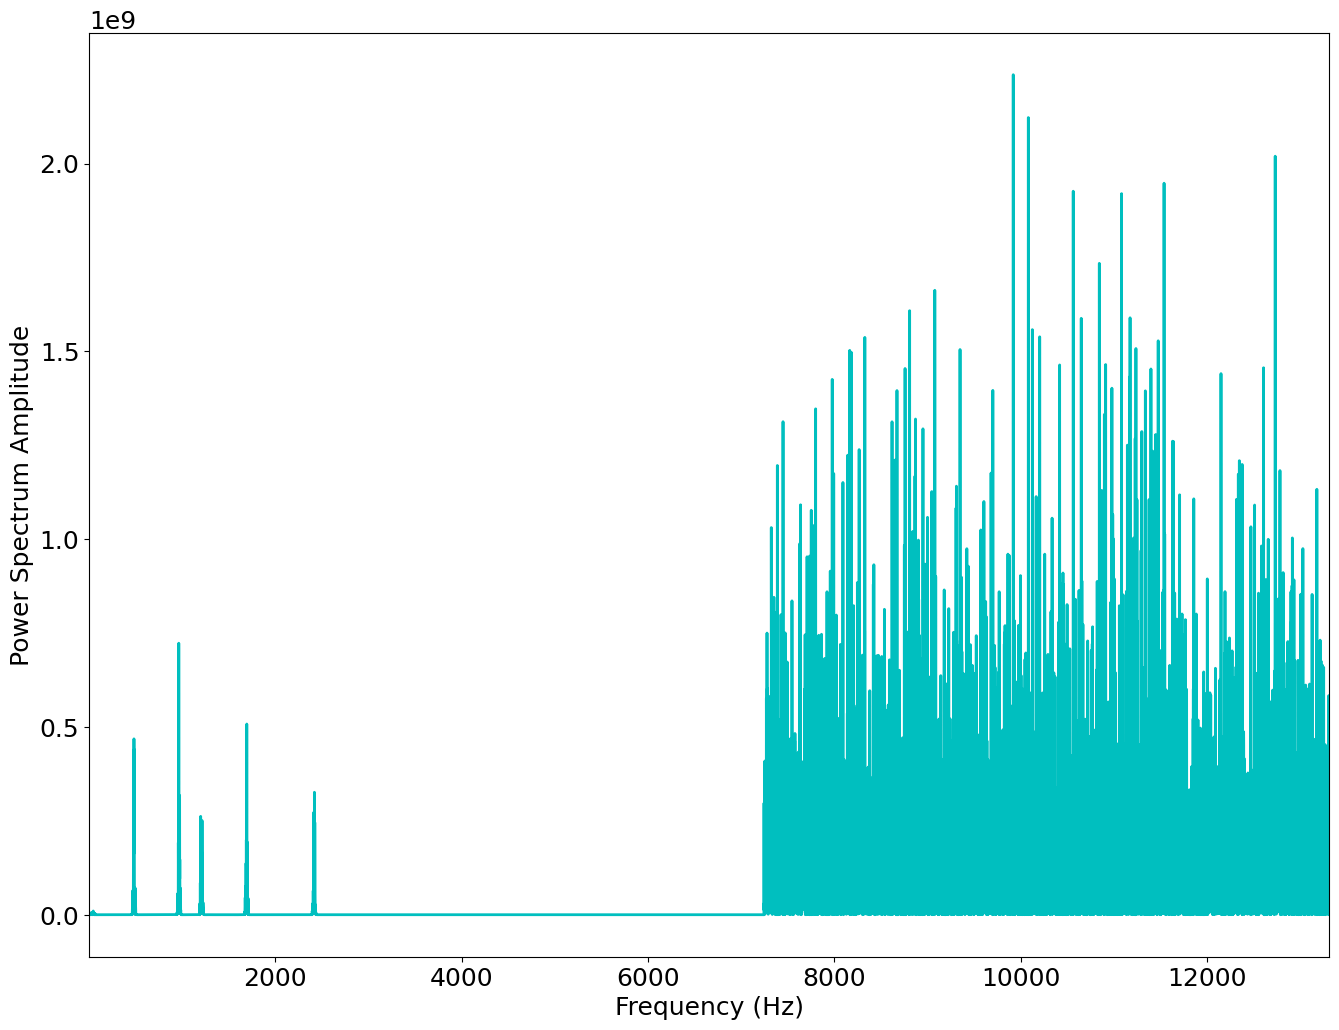

In [ ]:
n=len(audio_array)  # Find length of the time vector
AR_hat = np.fft.fft(audio_array,n)  #  Use the fast fourier transform on f
PSD = AR_hat * np.conj(AR_hat) / n    # Calculate the power spectrum
#freq = 1/(dt*n) * np.arange(n)    # Calculate the frequencies associated with fhat
L = np.arange(1, np.floor(n/2), dtype = 'int')

plt.plot(L,PSD[L], color = 'c', linewidth = 2)
#plt.plot(freq[L],PSD[L], color = 'c', linewidth = 2)
#plt.plot(freq[L], y_horizontal_line, color='red', linestyle='--')
#plt.xlim(freq[L[0]],freq[L[-1]])
plt.xlim(L[0],L[-1])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectrum Amplitude")
plt.show()


Decide what range of frequencies need to be eliminated.  In the cell below, you can enter a lower frequency and an upper frequency.  To eliminate to the top of the range, just input a frequency above the upper range of the $x$-axis.  The clean power spectrum is graphed down below.

What is lower range of frequency elimination (enter 0 if none)?:  6500
You entered: 6500
What is upper range of frequency elimination?:  15000


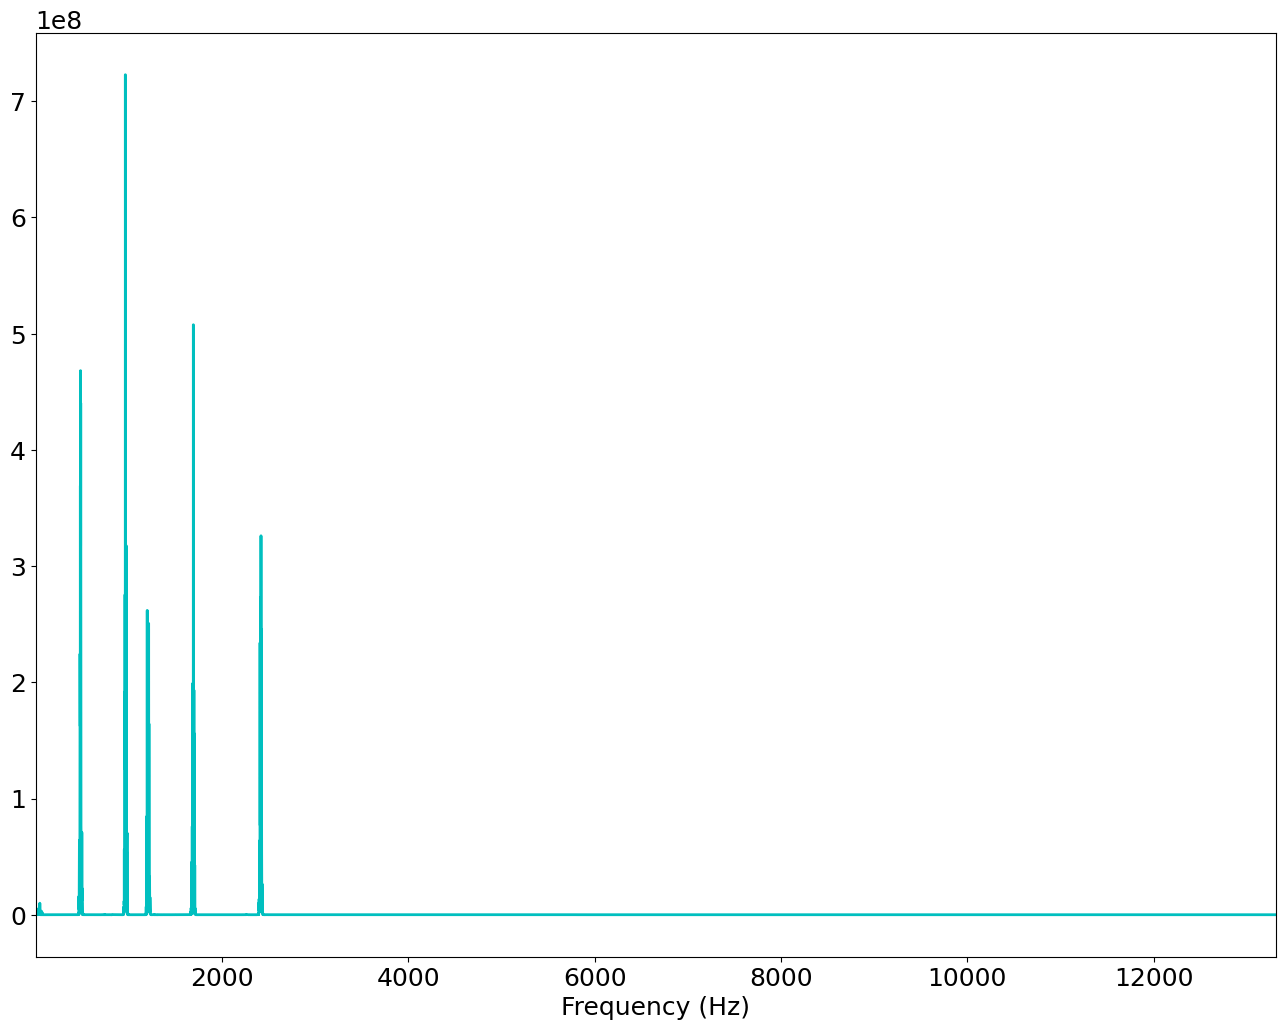

In [ ]:
first_frequency = get_integer_input_var("What is lower range of frequency elimination (enter 0 if none)?:  ")
print("You entered:", first_frequency)
if first_frequency>0:
  second_frequency = get_integer_input_var("What is upper range of frequency elimination?:  ")
  if second_frequency>first_frequency:
    AR_hat_clean=AR_hat
    AR_hat_clean[first_frequency:min(second_frequency,len(AR_hat_clean))]=0

PSD = AR_hat_clean * np.conj(AR_hat_clean) / n    # Calculate the power spectrum
#freq = 1/(dt*n) * np.arange(n)    # Calculate the frequencies associated with fhat
L = np.arange(1, np.floor(n/2), dtype = 'int')

plt.plot(L,PSD[L], color = 'c', linewidth = 2)
#plt.plot(freq[L],PSD[L], color = 'c', linewidth = 2)
#plt.plot(freq[L], y_horizontal_line, color='red', linestyle='--')
#plt.xlim(freq[L[0]],freq[L[-1]])
plt.xlim(L[0],L[-1])
plt.xlabel("Frequency (Hz)")
plt.show()

Now, inverse FFT this back into a regular audio file.  Have a listen.  Can you identify the speaker?

<ipython-input-9-3db2111b4cd4>:19: ComplexWarning: Casting complex values to real discards the imaginary part
  audio_bytes = (audio_array * 32767).astype(np.int16).tobytes()


Conversion completed. Wav file saved at: output.wav


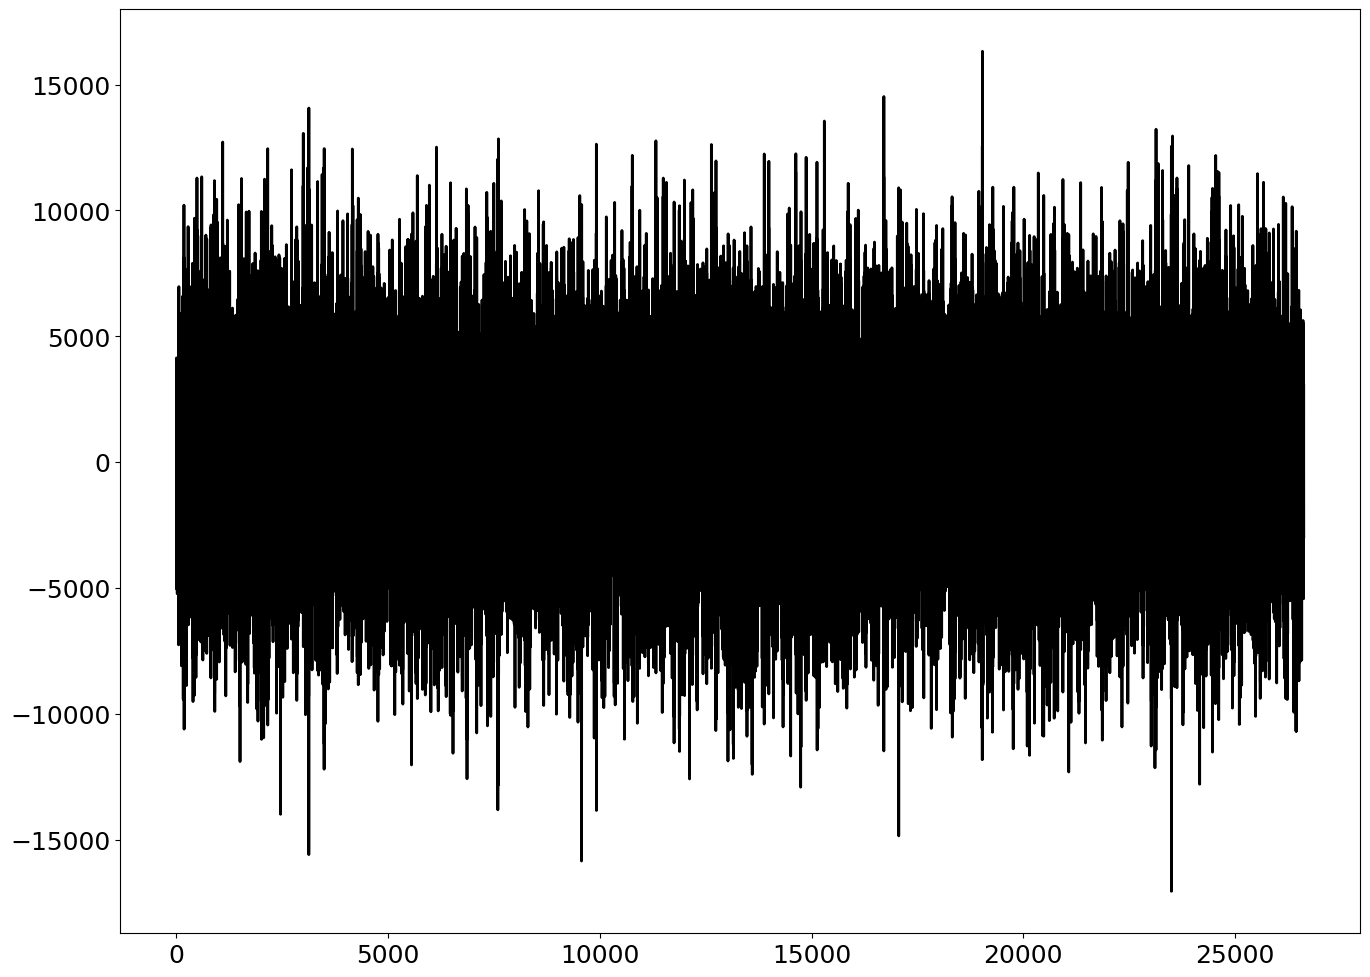

In [ ]:
AR_inverse=np.fft.ifft(AR_hat_clean)

plt.plot(AR_inverse, color = 'k', linewidth = 2, label = 'Inverted')

# Your Python array (replace this with your actual array)
audio_array = AR_inverse

# Specify the output .wav file path
output_file_path = 'output.wav'

# Create a wave file and write the audio data
with wave.open(output_file_path, 'w') as wave_file:
    # Set the parameters of the wave file
    wave_file.setnchannels(1)  # 1 channel for mono, 2 channels for stereo
    wave_file.setsampwidth(2)  # 2 bytes for 16-bit samples
    wave_file.setframerate(44100)  # Sample rate (e.g., 44100 Hz)

    # Convert the array to bytes and write it to the wave file
    audio_bytes = (audio_array * 32767).astype(np.int16).tobytes()
    wave_file.writeframes(audio_bytes)

print(f"Conversion completed. Wav file saved at: {output_file_path}")


Once you have looked at the audio file, go back and analyse the files with the other 12 numbers.

#C. Compressing a Photograph

In this section, we will be compressing a black and white photograph.  You will investigate how much information (and memory) you can ignore while still having a photograph that is clear.  

Start by taking a black and white selfie of your group and downloading it to AAAA.  We will then (unsurprisingly) FFT this into frequency space.  

The new thing here is that we are using a two dimensional FFT.  In the one dimensional Fourier transform, we start with a function $f(x)$, integrate over $x$ and end up with $\tilde{f}(\omega)$.  In two dimensions, we start with a function $f(x,y)$, execute a double integral over both $x$ and $y$ resulting in $\tilde{f}(\omega_{1},\omega_{2})$.  The photograph is represented digitally by a bunch of pixels, each with a location represented by $x$ and $y$ and an intensity which is $f(x,y)$.

(-0.5, 2015.5, 1511.5, -0.5)

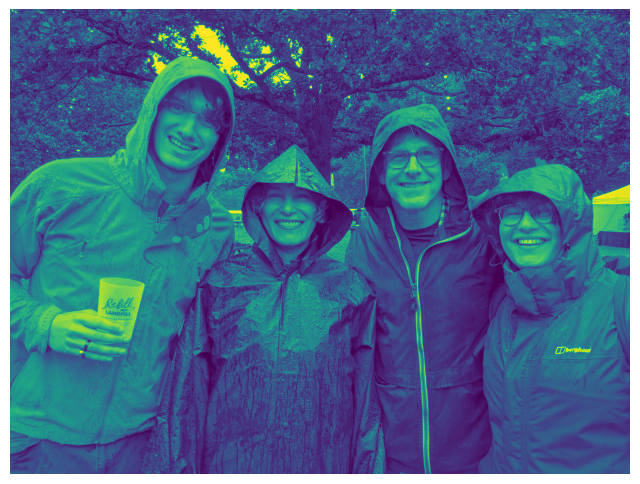

In [ ]:
plt.rcParams ['figure.figsize'] = [8, 8]

photo_file_path = '/content/gdrive/My Drive/Colab Notebooks/EalingBluesFestival2023.jpg'
A = imread(os.path.join('..','DATA',photo_file_path))
B = np.mean(A,-1)  #Convert RGB to greyscale

plt.figure()
plt.imshow(B)
plt.axis('off')

What fraction of data would you like to keep (0-1)?0.001


(-0.5, 2015.5, 1511.5, -0.5)

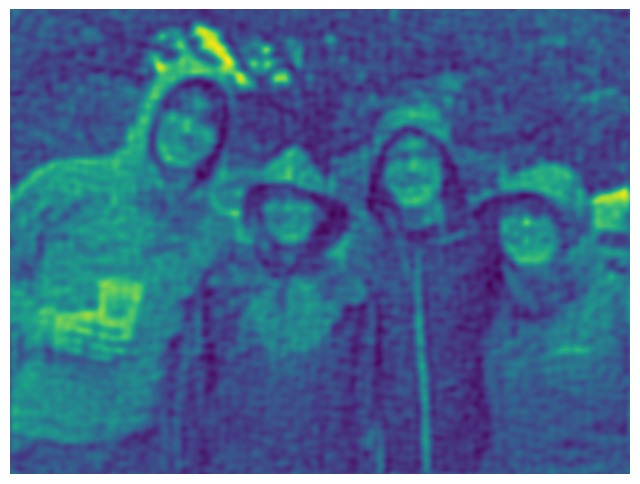

In [ ]:
Bt = np.fft.fft2(B)
Btsort = np.sort(np.abs(Bt.reshape(-1)))
frac_kept = get_real_number("What fraction of data would you like to keep (0-1)?")
frac_kept = min(max(frac_kept,0.0),1.0) #keep the threshold within a proper range
thresh = Btsort[int(np.floor((1-frac_kept)*len(Btsort)))]
ind = np.abs(Bt)>thresh
Btlow = Bt * ind
Blow = np.fft.ifft2(Btlow).real

plt.figure()
plt.imshow(Blow)
plt.axis('off')

Upload various jpeg files and analyse them.  In particular, look at the compression possibilities for photos that are "smooth" versus ones with lots of details like hair, grass or leaves.